# Data Processing and Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

plt.style.use('ggplot')
data_dir = '../Input'
report_dir = '../Report'
output_dir ='../Output'


### Data loading and Pre-Processing

In [2]:
metadata_train = pd.read_csv(data_dir + '/metadata_train.csv', sep = ",")

In [3]:
features_raw = pd.read_csv(output_dir + '/all_features.csv', sep=";")
target = features_raw.target

# drop the unecessary features
X = features_raw.drop(['Unnamed: 0', 'signal_id', 'id_measurement', 'phase','target','max_freq_spectrum_p1','max_freq_spectrum_p2','max_freq_spectrum_p3','max_freq_spectrum_p4'], axis = 1).copy()

# Store the column name information
columns = X.columns

First, the data should be normalized because the features have very different magnitudes. This will be done using the StandardScaler function.

In [4]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns)

In [5]:
def plot_distribution(X, columns, title):
    sp = np.reshape(np.arange(40), (8,5))
    f, axes = plt.subplots(8, 5, figsize=(12, 24))
    f.suptitle(title,size=16)

    index_row = 0
    index_col = 0
    for row in sp:
        for col in row:
            sns.distplot(X[columns[col]], label= columns[col], ax=axes[index_row, index_col])
            axes[index_row, index_col].axvline(X[columns[col]].mean(), color='b', linestyle='--')
            axes[index_row, index_col].axvline(X[columns[col]].median(), color='g', linestyle='-')
            axes[index_row, index_col].legend(['Mean','Median'])

            index_col+=1
        
        index_row+=1
        index_col = 0
    
    f.tight_layout()
    f.subplots_adjust(top=0.95)
    return f


C:\Users\Victor\AppData\Local\conda\conda\envs\dev-capstone\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


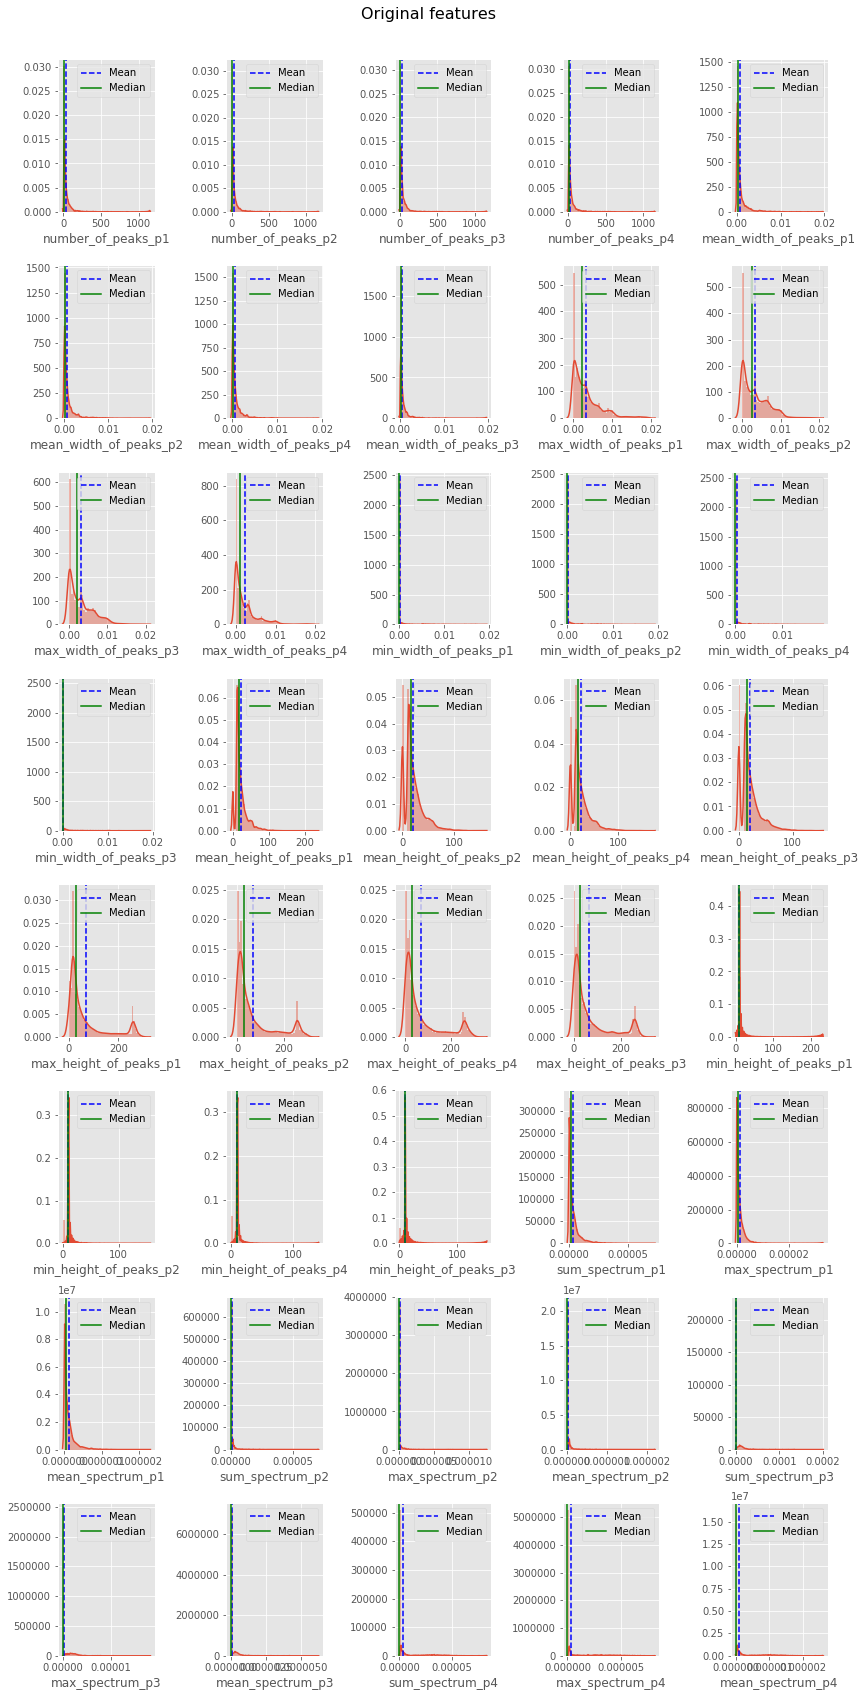

In [6]:
plot_distribution(X, columns, 'Original features').savefig(report_dir + '/dist_original.png')

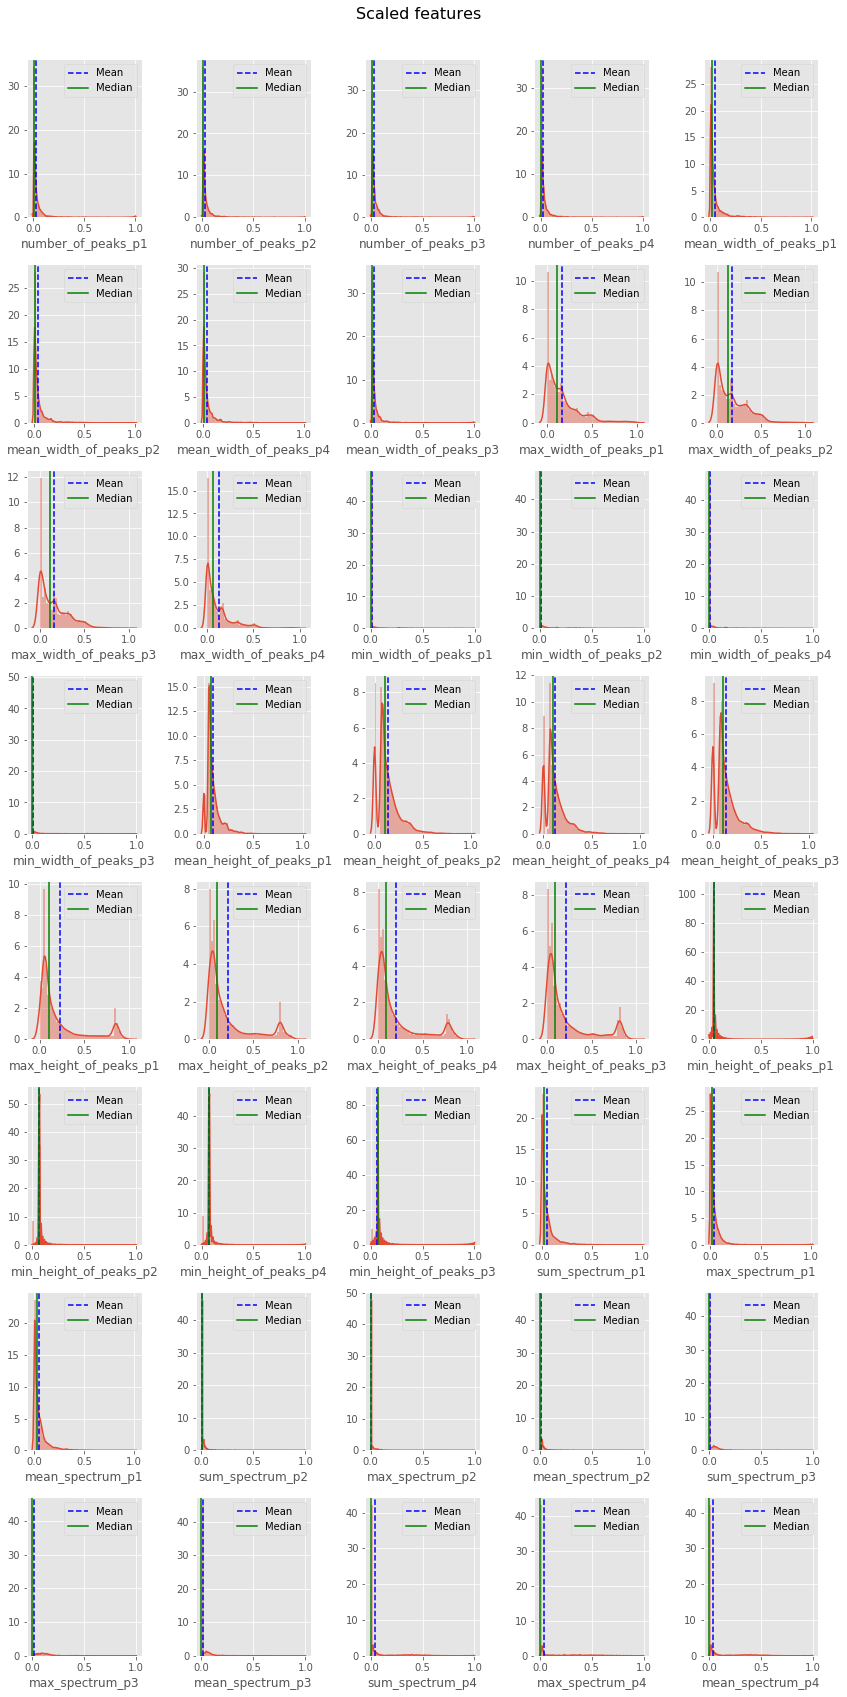

In [7]:
plot_distribution(X_scaled, columns, 'Scaled features').savefig(report_dir + '/dist_minmax_scaled.png')

As we can see, the scaled data is much better than before. Moreover, the features are very skewed towards 0 and the data does not look normally distributed. In order to fix that, the natural logarithm will be applied to the features where the mean and median are very different.

In [8]:
diff_mean_median = pd.DataFrame()
diff_mean_median['Mean'] = X_scaled.mean()
diff_mean_median['Median'] = X_scaled.median()
diff_mean_median['Diff'] = diff_mean_median.apply(lambda x: abs(x.Mean - x.Median), axis = 1)

In [9]:
diff_mean_median.sort_values('Diff')

,Mean,Median,Diff
min_height_of_peaks_p1,0.044509,0.043981,0.000528
min_height_of_peaks_p2,0.062426,0.064999,0.002573
min_height_of_peaks_p4,0.068659,0.072488,0.003830
min_height_of_peaks_p3,0.063039,0.067334,0.004295
max_spectrum_p2,0.006327,0.000545,0.005782
min_width_of_peaks_p3,0.006968,0.000002,0.006966
sum_spectrum_p2,0.008807,0.001115,0.007692
mean_spectrum_p2,0.008807,0.001115,0.007692
mean_spectrum_p3,0.011156,0.000363,0.010793
sum_spectrum_p3,0.011156,0.000363,0.010793


As we can see, the mean and median are very distant for every feature. Therefore, the transformation will be applied for all the features.

In [10]:
X_log_scaled = X_scaled.apply(lambda x: np.log(x + 1), axis = 1)

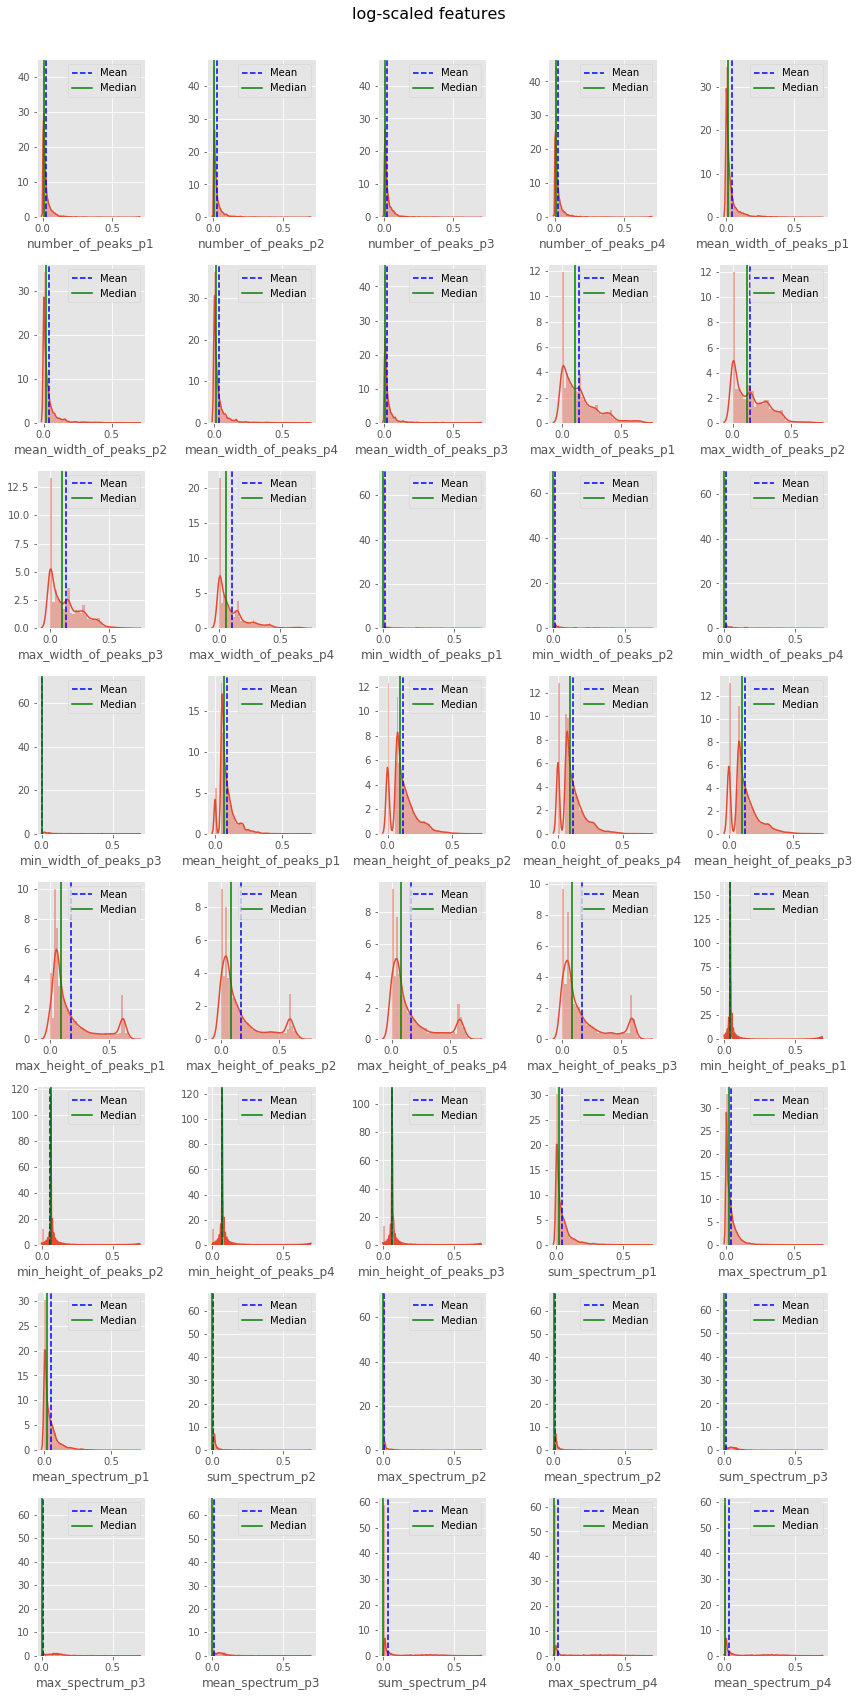

In [11]:
plot_distribution(X_log_scaled, columns, 'log-scaled features').savefig(report_dir + '/dist_minmax_scaled_log.png')

### Feature selection

In order to select the most relevant features, a Tree-based approach will be used.

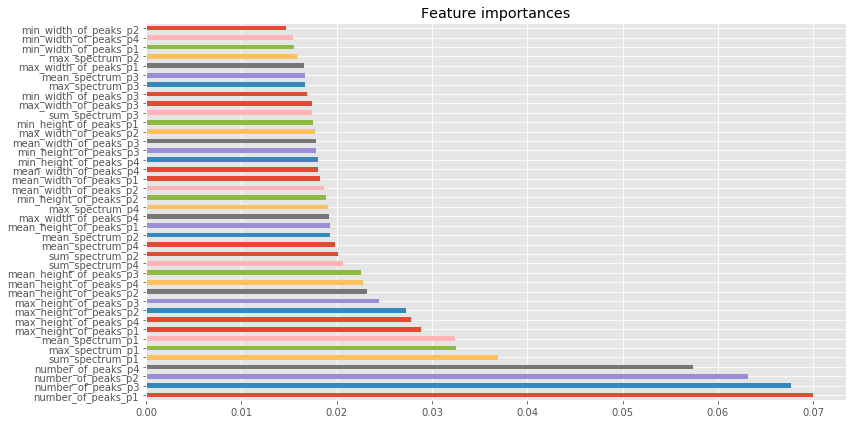

In [12]:
X, y = X_log_scaled, target
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X, y)

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh', figsize=(12,6))
plt.title('Feature importances')
plt.tight_layout()
plt.savefig(report_dir + '/feature_importances.png')

In [13]:
model = SelectFromModel(clf, prefit=True)

feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_best_features = pd.DataFrame(model.transform(X), columns = feature_name)

print('The most important features are {}'.format(feature_name.values))

The most important features are ['number_of_peaks_p1' 'number_of_peaks_p2' 'number_of_peaks_p3'
 'number_of_peaks_p4' 'max_height_of_peaks_p1' 'max_height_of_peaks_p2'
 'max_height_of_peaks_p4' 'sum_spectrum_p1' 'max_spectrum_p1'
 'mean_spectrum_p1']


In [14]:
X_best_features.shape

(8712, 10)

In [15]:
X_best_features['target'] = target
X_best_features.to_csv(output_dir + '/data_modeling.csv', sep=";")
X_best_features.drop('target', axis = 1, inplace=True)

### Models Learning and Evaluation

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [17]:
# The naive predictor always predict the 0 class. It will achieve a 93.97% accuracy score always. 
def naive_predictor(x):
    return 0

In [18]:
predictions = metadata_train.target.apply(naive_predictor)

mcc_naive = matthews_corrcoef(metadata_train.target, predictions)  
acc_naive = accuracy_score(metadata_train.target, predictions)  
auc_naive = roc_auc_score(metadata_train.target, predictions)

print('MCC value for the naive predictor (baseline): {}'.format(mcc_naive))
print('Accuracy value for the naive predictor (baseline): {}%'.format(100 *acc_naive))
print('AUC value for the naive predictor (baseline): {}'.format(auc_naive))

MCC value for the naive predictor (baseline): 0.0
Accuracy value for the naive predictor (baseline): 93.97382920110194%
AUC value for the naive predictor (baseline): 0.5


C:\Users\Victor\AppData\Local\conda\conda\envs\dev-capstone\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### Model Learning

Initially, a few models will be evaluated using cross-validation.

* Logistic Regression
* kNN
* Random Forest
* Gradient Boosting

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_best_features, target, test_size = 0.2, random_state = 7)


In [ ]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs')))
models.append(('kNN', KNeighborsClassifier()))
models.append(('Random Forest', RandomForestClassifier(n_estimators=10)))
models.append(('Gradient Boosting', GradientBoostingClassifier()))

X, Y = X_train, y_train

seed = 7

results = []
names = []
scoring =  make_scorer(matthews_corrcoef)
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)

    names.append(name)
    msg = "%s: MCC: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



C:\Users\Victor\AppData\Local\conda\conda\envs\dev-capstone\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Logistic Regression: MCC: 0.193171 (0.081982)
kNN: MCC: 0.489955 (0.064005)
Random Forest: MCC: 0.524059 (0.052860)
Gradient Boosting: MCC: 0.521349 (0.042913)


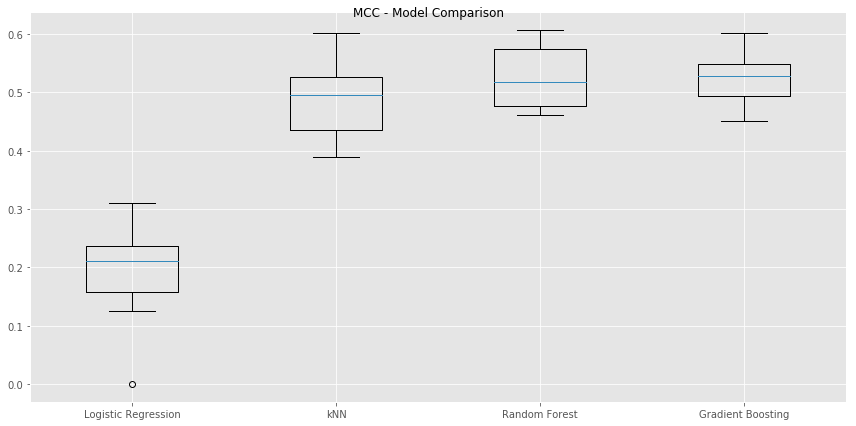

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,6))
fig.suptitle('MCC - Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.tight_layout()
plt.savefig(report_dir + '/model_cross_val_trial.png')

### Model Refinement

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [10, 30, 50, 100, 150, 200, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 30, 50, 70, 100]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [ ]:
# Create the random forest classifier
rf = RandomForestClassifier(random_state=7)

# Create the scorer
scorer_mcc =  make_scorer(matthews_corrcoef)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = 4, cv = None,  scoring = scorer_mcc, verbose=5)
                           
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


C:\Users\Victor\AppData\Local\conda\conda\envs\dev-capstone\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  4.6min


In [ ]:
display(grid_search.best_params_)

best_grid = grid_search.best_estimator_

grid_mcc_train = matthews_corrcoef(best_grid.predict(X_train), y_train)
grid_mcc_test = matthews_corrcoef(best_grid.predict(X_test), y_test)

display('Train MCC value for the RF optimized predictor: {}'.format(grid_mcc_train))
display('Test MCC value for the RF optimized predictor: {}'.format(grid_mcc_test))

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr, tpr, threshold = roc_curve(y_test, best_grid.predict(X_test))
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(report_dir + '/roc_test.png')

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

cnf_matrix = confusion_matrix(y_test, best_grid.predict(X_test))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','Faulted'],
                      title='Confusion matrix')
plt.savefig(report_dir + '/cnf_matrix_testset.png')